In [1]:
import numpy as np
from read_db.CH import Getch
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from random import seed

sns.set(rc={'figure.figsize': (16, 10)}, style='whitegrid')

In [2]:
begin_date_str = '2022-03-15'
end_date_str = '2022-03-21'
groups_tuple = (2,1)

q = f"""SELECT  exp_group,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
FROM simulator_20220320.feed_actions 
WHERE toDate(time) between '{begin_date_str}' and '{end_date_str}'
    and exp_group in {groups_tuple}
GROUP BY exp_group, user_id
"""
#The BETWEEN operator is inclusive: begin and end values are included.

In [3]:
df = Getch(q).df
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


In [4]:
df2 = df.query('exp_group == 2').drop('exp_group', axis = 1)
df1 = df.query('exp_group == 1').drop('exp_group', axis = 1)
df2.shape, df1.shape

((9952, 4), (10079, 4))

## Cравнить CTR в двух группах:

### 0) глазами


<AxesSubplot:xlabel='ctr', ylabel='Count'>

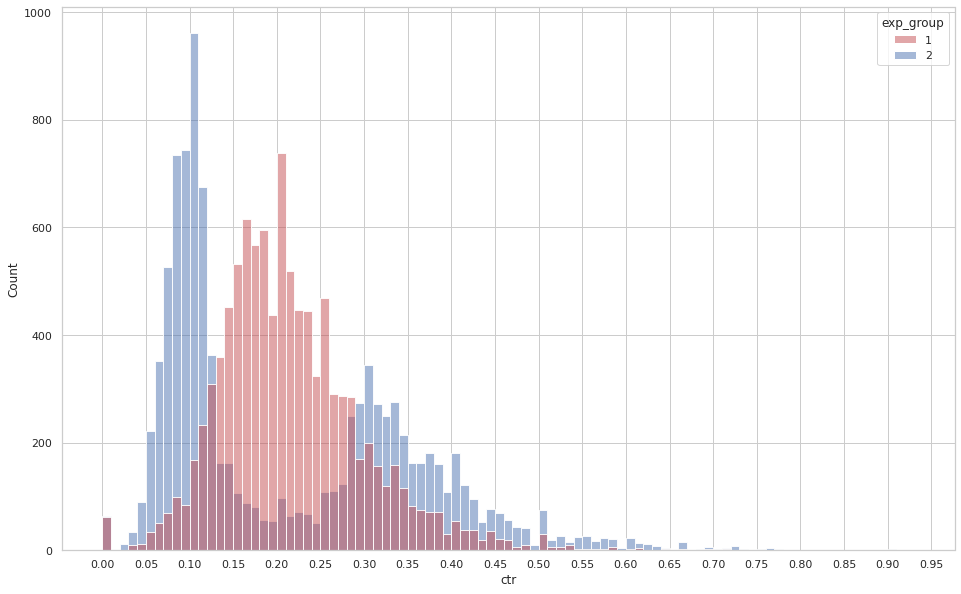

In [5]:
plt.xticks(np.arange(0.0, 1, 0.05))
sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r','b'], binwidth=0.01) #bins=np.linspace(0.0, 0.8, 80))

Распределение CTR в контрольной группе (1) несколько похоже на нормальное (унимодально, довольно симметрично); в экспериментальной (2) оно изменилось так,\
что большая часть пользователей стала лайкать меньше постов (левый горб), однако некоторая часть стала лайкать больше ("горбики" справа).

Какая часть больше?

In [6]:
def get_ctr_thresholds_parts_diffs(df, threshold1, threshold2):
    return len(df[df.ctr <= threshold1]) / len(df) - len(df[df.ctr >= threshold2]) / len(df)

In [7]:
#Значения отсечек взяты из гистограммы как "дальняя от 0.2 граница первого бина, у которого количество элементов 2 группы больше (синий бин выше)"
th1 = 0.14
th2 = 0.27
print(f'{get_ctr_thresholds_parts_diffs(df2, th1, th2)*100:.2f}%')

10.54%


Ставших лайкать меньше оказалось больше (pun not intended).

### 1) t-тест

In [8]:
stats.ttest_ind(a=df1.ctr, b=df2.ctr, equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

In [9]:
(df1.ctr.mean(), df1.ctr.var()), (df2.ctr.mean(), df2.ctr.var())

((0.21560459841296287, 0.0070828247094791436),
 (0.21441927347479375, 0.02078786783139333))

In [10]:
statistic = (df1.ctr.mean() - df2.ctr.mean()) /  np.sqrt(df1.ctr.var()/len(df1) + df2.ctr.var()/len(df2))
statistic == 0.7094392041270486

False

In [11]:
pval = 1 - (stats.t.cdf(statistic, df=len(df1)+len(df2)-2) - stats.t.cdf(-statistic, df=len(df1)+len(df2)-2))
pval

0.47806022470167875

In [12]:
pval - 0.4780623130874935

-2.0883858147247025e-06

### 2) Пуассоновский бутстреп

In [13]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


def bootstrap_df(df, n_bootstrap=2000):
    seed(len(df))    
    poisson_bootstraps = stats.poisson(1).rvs((n_bootstrap, len(df))).astype(np.int64)
    global_CTR = (poisson_bootstraps * df.likes.to_numpy()).sum(axis=1) / (poisson_bootstraps * df.views.to_numpy()).sum(axis=1)
    
    return global_CTR

In [14]:
ctr1 = bootstrap_df(df1)
ctr2 = bootstrap_df(df2)

<AxesSubplot:ylabel='Count'>

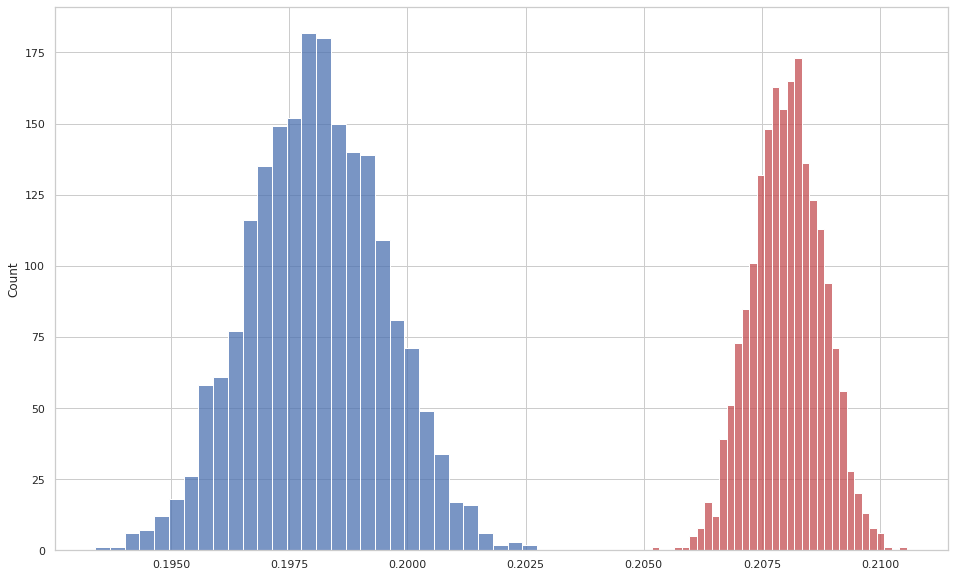

In [15]:
sns.histplot(ctr1, color='r')
sns.histplot(ctr2, color='b')

<AxesSubplot:ylabel='Count'>

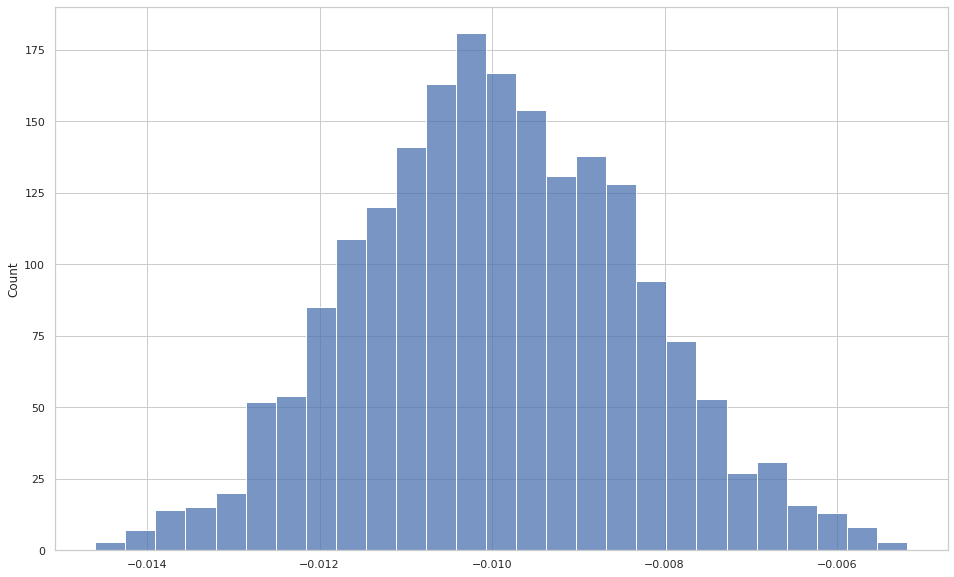

In [16]:
sns.histplot(ctr2 - ctr1)

Разница между глобальными CTR не включает 0, а это значит, что они отличаются.

### 3) тест Манна-Уитни

In [17]:
stats.mannwhitneyu(x=df1.ctr, y=df2.ctr, alternative='two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

### 4) t-тест на сглаженном ctr (α=5)


In [18]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr


def get_smoothed_ctr_df(df, alpha=5):
    global_ctr = df.likes.sum() / df.views.sum()
    smoothed_ctr = (df.likes + alpha * global_ctr) / (df.views + alpha)
    return smoothed_ctr

In [19]:
smoothed_ctr1 = get_smoothed_ctr_df(df1)
smoothed_ctr2 = get_smoothed_ctr_df(df2)
len(smoothed_ctr1), len(smoothed_ctr2)

(10079, 9952)

<AxesSubplot:ylabel='Count'>

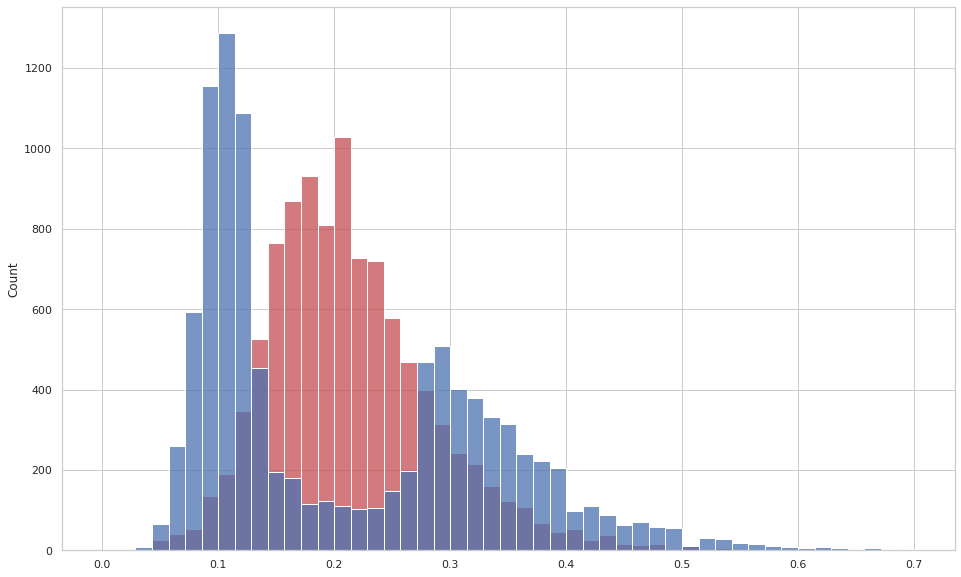

In [20]:
# sns.distplot(smoothed_ctr1, kde=False)
# sns.distplot(smoothed_ctr2, kde=False)

bins = np.linspace(0.0, 0.7)
sns.histplot(smoothed_ctr1, bins=bins, color='r')
sns.histplot(smoothed_ctr2, bins=bins, color='b')

In [21]:
stats.ttest_ind(a=smoothed_ctr1, b=smoothed_ctr2, equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [22]:
smoothed_ctr1.mean(), smoothed_ctr2.mean()

(0.21402549608884142, 0.21073955503259234)

In [23]:
bucket_q = f"""SELECT   exp_group,
                        bucket,
                        sum(likes) / sum(views) as bucket_ctr
FROM
(
    SELECT  exp_group,
            xxHash64(user_id)%50 as bucket,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
    FROM simulator_20220320.feed_actions 
    WHERE toDate(time) between '{begin_date_str}' and '{end_date_str}'
        and exp_group in {groups_tuple}
    GROUP BY exp_group, bucket, user_id
)
GROUP BY exp_group, bucket
"""

In [24]:
bucket_df = Getch(bucket_q).df
bucket_df

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271
...,...,...,...
95,2,47,0.195880
96,1,48,0.212787
97,2,48,0.194502
98,1,49,0.203169


In [25]:
bucket_ctr1 = bucket_df[bucket_df.exp_group == 1].bucket_ctr
bucket_ctr2 = bucket_df[bucket_df.exp_group == 2].bucket_ctr
bucket_ctr1.shape, bucket_ctr2.shape

((50,), (50,))

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

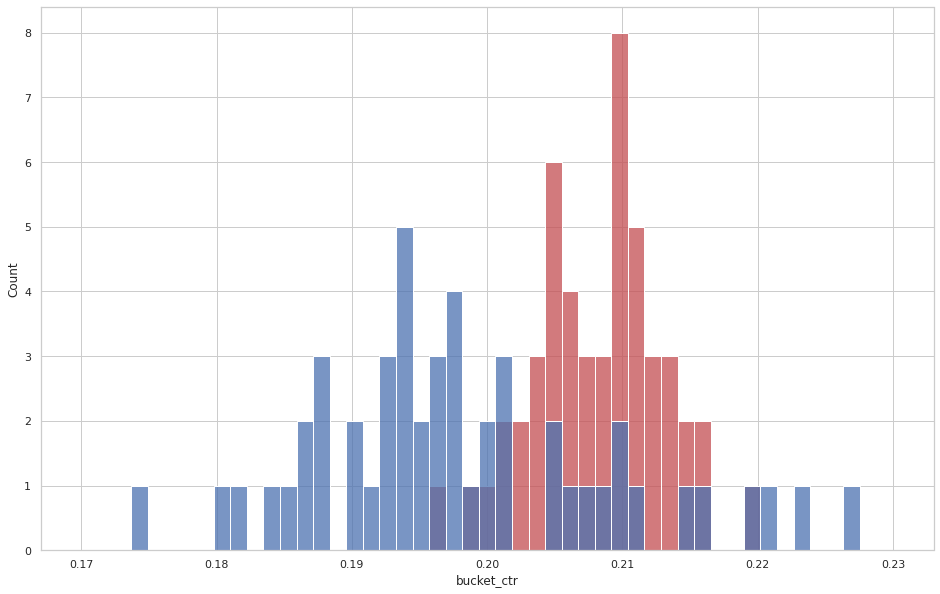

In [26]:
bins = np.linspace(0.17, 0.23)
sns.histplot(bucket_ctr1, bins=bins, color='r')
sns.histplot(bucket_ctr2, bins=bins, color='b')

### 5) t-тест поверх бакетного преобразования


In [27]:
stats.ttest_ind(bucket_ctr1, bucket_ctr2, equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [28]:
bucket_ctr1.mean(), bucket_ctr2.mean()

(0.20812170724336013, 0.19825944666552928)

### 6) тест Манна-Уитни поверх бакетного преобразования



In [29]:
stats.mannwhitneyu(bucket_ctr1, bucket_ctr2, alternative='two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

# Результаты (краткие):
### 0) глазами

Распределения различаются: формы очень разные (группа 1 одногорбая, 2 - двугорбая), есть только один столбик равной высоты для обоих групп (у 0.00), "на глаз" можно предположить, что среднее окажется равным. 

### 1) t-тест

$pvalue=0.47806231308748337 > 0.05$

Не получено доказательств, позволяющих утверждать, что средние значения CTR в группах 1 и 2 отличаются.


### 2) Пуассоновский бутстреп

Разница между распределениями не включает 0, значит, они различаются.

### 3) тест Манна-Уитни

$pvalue=6.0376484617779035e-56 < 0.05$

Группы стохастически неравны: $P(X>Y) \neq P(Y>X)$ для случайных элементов $X, Y$. 

### 4) t-тест на сглаженном CTR (α=5)

$pvalue=0.0223769815558559 < 0.05$

Получены доказательства, позволяющие утверждать, что средние значения CTR в группах 1 и 2 отличаются.


### 5) t-тест поверх бакетного преобразования

$pvalue=3.4455951649945907e-07 < 0.05$

Получены доказательства, позволяющие утверждать, что средние значения CTR в группах 1 и 2 отличаются.

### 6) тест Манна-Уитни поверх бакетного преобразования

$pvalue=2.859963936492646e-07 < 0.05$

Группы стохастически неравны: $P(X>Y) \neq P(Y>X)$ для случайных элементов $X, Y$. 

## Почему тесты сработали так как сработали?
(Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.)

### Ситуации, в которых нет противоречий:
1) Глаза (0) и пуассоновский бутстреп (2): выборки отличаются, во втором случае можно даже посмотреть распределение разницы (в первом это сделать без потерь не получится из-за разного размера выборок, разве только начать наугад набирать подвыборки... что приведёт нас во второй случай).

2) t-тесты на сглаженном CTR (4) и поверх бакетного преобразования (5) дали один и тот же результат: доказательства того, что средние значения CTR в группах 1 и 2 отличаются.

3) Тесты Манна-Уитни над оригинальной выборкой (3) и поверх её бакетного преобразования (6) дал один и тот же результат:\
Посмею предположить, что возможной интерпретацией нулевой гипотезы теста Манна-Уитни является ответ на вопрос "похожи ли выборки: похожи ли их формы и/или близки ли их средние и/или медианы". В этих случаях они непохожи, как минимум по форме и из-за этого очень сложно вытащить случайные $X,Y: P(X>Y) = P(Y>X)$.

### Противоречие:
t-тесты для оригинального CTR (1) и для сглаженного (4) и/или поверх бакетного преобразования (5):\
Предположу, что t-test (1) не отвергает равенство средних потому, что выборочные средние чрезвычайно близки, поэтому их разница (числитель статистики) чрезвычайно мал.\
В случаях (4) и (5) отличия выборочных средних гораздо больше $\to$ статистика больше $\to$ p-value меньше $\to$ легче отклонить Н0.

#### Update.
Согласно [материалам Никиты Маршалкина](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#d2d3) большую роль в уменьшении силы t-теста играет скошенность распределения:\
*As you can see, higher skewness drops the power of the t-test significantly. Furthermore, for very skewed distributions, t-test p-values clearly don’t follow uniform distribution under H0. In the region of small values, p-values overestimate FPR (the plot lies beyond diagonal in this region). It becomes a “conservative” estimate of FPR. It is fine to use this test, as we can still be sure that FPR <= p-value, but the power of the test is low.
The main reason for this is the strong violation of the normality assumption for highly skewed distribution. If the views distribution is heavily skewed, clicks distribution will be skewed as well. The more it is skewed, the more samples (users) are required to restore the sample’s mean normality.\
...\
Therefore, if your data is heavily skewed, consider using the MW test instead of a t-test. But when the skewness is low, a t-test might be a better alternative. If you’re working with big data, the computational complexity of the MW test might be challenging to deal with.*


In [30]:
for c,t in ((df1.ctr, df2.ctr), (smoothed_ctr1, smoothed_ctr2), (bucket_ctr1, bucket_ctr2)):
    print(c.skew(), t.skew())
    
stats.skew(ctr1), stats.skew(ctr2)

1.0177755544972016 0.8346301249835312
0.8946564217576878 0.7244860728969691
-0.13242953106852376 0.5684650933485372


(-0.02650821550030397, 0.016151935642578913)

Согласно rule of thumb [отсюда](https://community.gooddata.com/metrics-and-maql-kb-articles-43/normality-testing-skewness-and-kurtosis-241) CTR бакетных преобразований близки к низкой скошенности ("approximately symmetric data" $-$ абсолютное значение скошенности меньше 0.5), сглаженные являются довольно скошенными (от 0.5 до 1.0), исходный тест довольно скошен, исходный контроль очень скошен (больше 1.0).

Последнее странно, так как в сравнении с тестом исходный контроль кажется менее скошенным.

(Скошенность бутстрапированных CTR очень мала.)

## Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

Я бы не стал: разницы либо нет, либо она не в пользу алгоритма $-$ в результате эксперимента "лайкающих меньше стало больше".